Plan:
* simple fullspace example
* solve a halfspace example
* do the south america example

# Fullspace example

In [3]:
from cutde import disp_all_pairs
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [2]:
nobs = 50
W = 2000
zoomx = [-W, W]
zoomy = [-W, W]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)
pts = np.array([obsx, obsy, 0*obsy]).reshape((3, -1)).T.copy()

In [3]:
fault_L = 1000
fault_H = 1000
fault_D = 0
fault_pts = np.array([
    [-fault_L, 0, -fault_D], 
    [fault_L, 0, -fault_D], 
    [fault_L, 0, -fault_D - fault_H], 
    [-fault_L, 0, -fault_D - fault_H]
])
fault_tris = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.int64)

slip = np.zeros((2, 3))
slip[:, 0] = 1.0

In [4]:
disp_mat = disp_all_pairs(pts, fault_pts[fault_tris], slip, 0.25)
disp = np.sum(disp_mat, axis=1).reshape((nobs, nobs, 3))

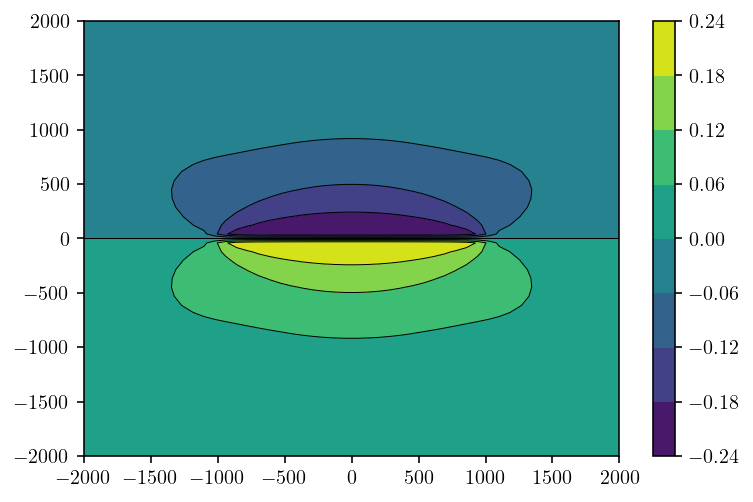

In [5]:
levels = np.linspace(0.20,0.20,11)
cntf = plt.contourf(obsx, obsy, disp[:, :, 0])#, levels = levels, extend="both")
plt.contour(obsx, obsy, disp[:, :, 0], colors='k', linestyles='-', linewidths=0.5)#, levels = levels, extend="both")
#plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

# Halfspace example

In [6]:
import okada_wrapper

In [98]:
lambda_ = 3e10
mu = 3e10
alpha = (lambda_ + mu) / (lambda_ + 2 * mu)

okada_disp = np.empty_like(pts)
for i in range(pts.shape[0]):
    success, okada_disp[i], _ = okada_wrapper.dc3dwrapper(alpha, pts[i].tolist(),
                          fault_D + fault_H / 2.0, 90, [-fault_L, fault_L], [-fault_H/2.0, fault_H/2.0],
                          [1.0, 0.0, 0.0])
    assert(success == 0)
okada_disp = okada_disp.reshape((nobs, nobs, 3))

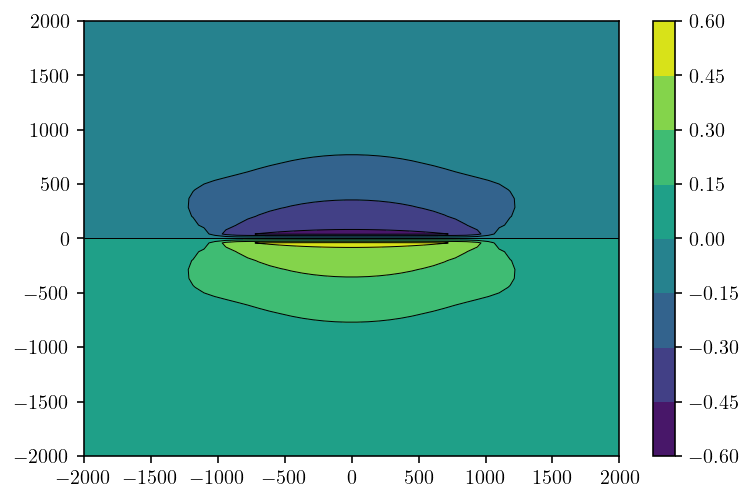

In [99]:
levels = np.linspace(0.20,0.20,11)
cntf = plt.contourf(obsx, obsy, okada_disp[:, :, 0])#, levels = levels, extend="both")
plt.contour(obsx, obsy, okada_disp[:, :, 0], colors='k', linestyles='-', linewidths=0.5)#, levels = levels, extend="both")
#plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

In [81]:
surf_L = 4000
n_els_per_dim = 50
mesh_xs = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
mesh_ys = np.linspace(-surf_L, surf_L, n_els_per_dim + 1)
mesh_xg, mesh_yg = np.meshgrid(mesh_xs, mesh_ys)
surf_pts = np.array([mesh_xg, mesh_yg, 0*mesh_yg]).reshape((3, -1)).T.copy()
surf_tris = []
nx = ny = n_els_per_dim + 1
idx = lambda i, j: i * ny + j
for i in range(n_els_per_dim):
    for j in range(n_els_per_dim):
        x1, x2 = mesh_xs[i:i+2]
        y1, y2 = mesh_ys[j:j+2]
        surf_tris.append(
            [idx(i, j), idx(i + 1, j), idx(i + 1, j + 1)]
        )
        surf_tris.append(
            [idx(i, j), idx(i + 1, j + 1), idx(i, j + 1)]
        )
surf_tris = np.array(surf_tris, dtype=np.int64)

In [82]:
surf_tri_pts = surf_pts[surf_tris]
surf_centers = np.mean(surf_tri_pts, axis = 1)

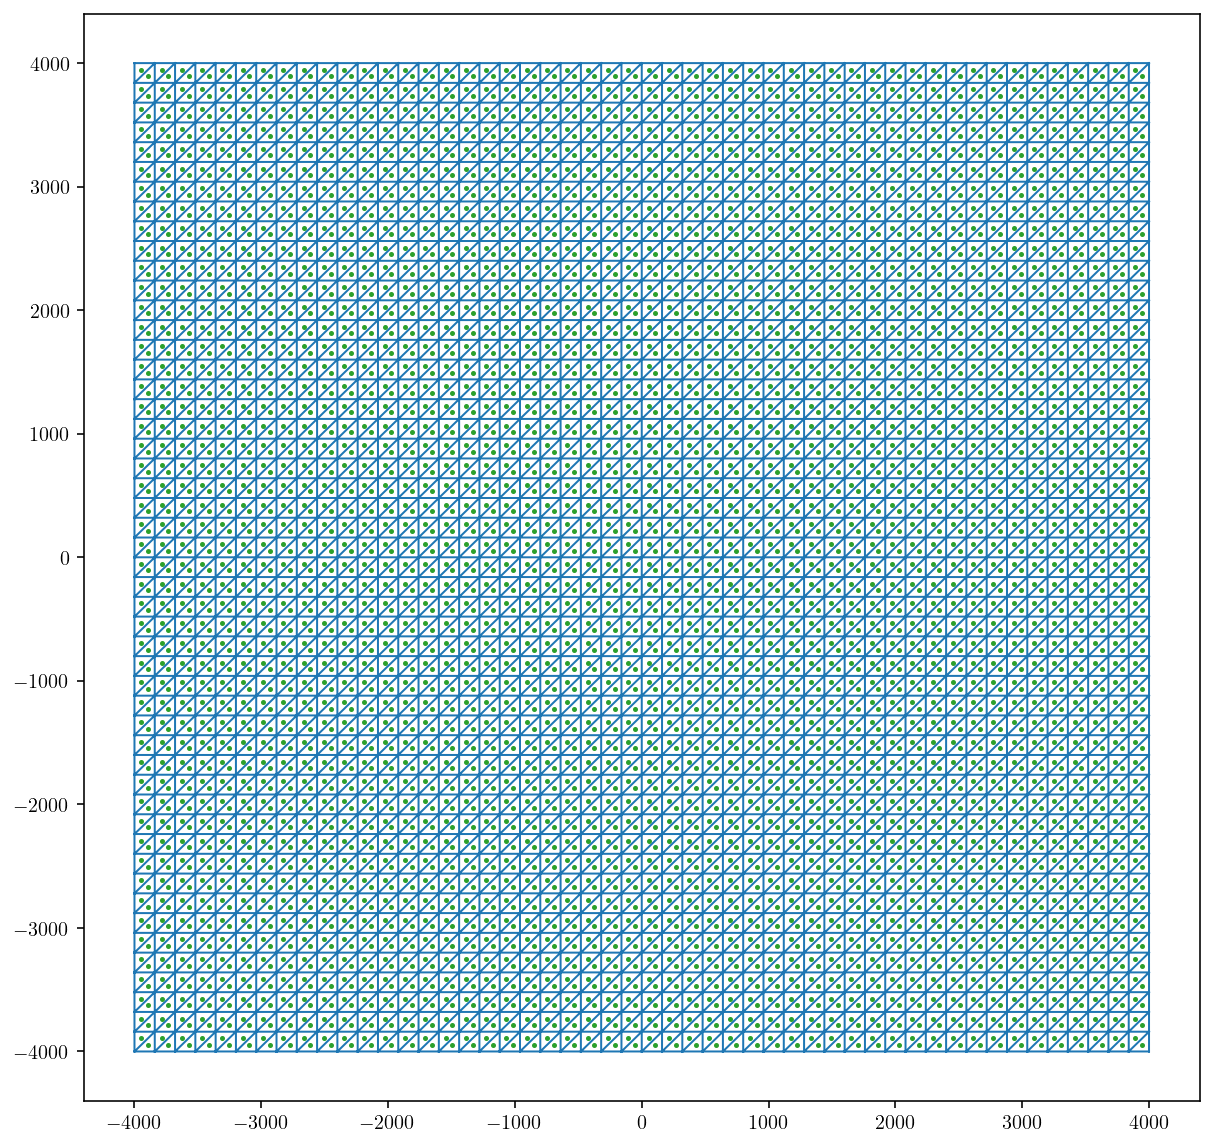

In [83]:
plt.figure(figsize = (10, 10))
plt.triplot(surf_pts[:, 0], surf_pts[:, 1], surf_tris, linewidth = 1.0)
plt.plot(surf_centers[:, 0], surf_centers[:, 1], '.', markersize=3)
plt.show()

In [144]:
fault_surf_mat = disp_all_pairs(surf_centers, fault_pts[fault_tris], slip, 0.25)

In [150]:
surf_surf_mats = []
for d in range(3):
    fictitious_slip = np.zeros((surf_tris.shape[0], 3))
    fictitious_slip[:, d] = 1.0
    surf_centers = np.mean(surf_tri_pts, axis = 1)
    surf_surf_mats.append(disp_all_pairs(surf_centers, surf_pts[surf_tris], fictitious_slip, 0.25))
surf_surf_mat = np.array(surf_surf_mats)

In [153]:
lhs = np.transpose(surf_surf_mat, (1, 3, 2, 0)).reshape((surf_tris.shape[0] * 3, surf_tris.shape[0] * 3))
rhs = np.sum(fault_surf_mat, axis=1)
soln = np.linalg.solve(lhs, rhs.flatten()).reshape((-1, 3))

# TDEs don't work!! Or so we thought...

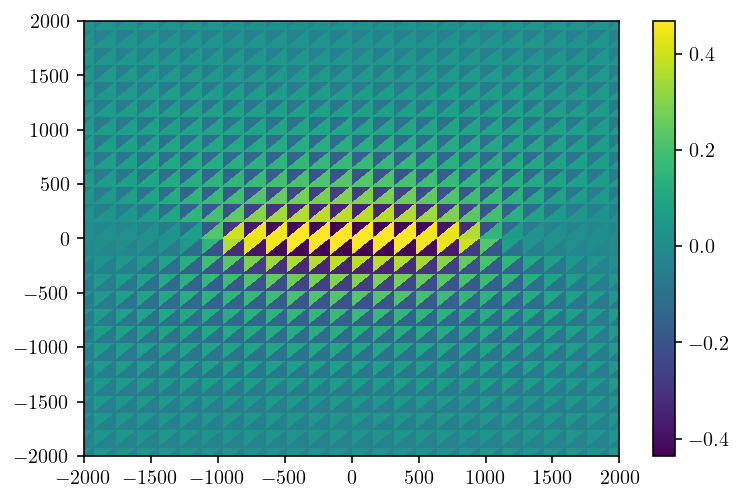

In [154]:
levels = np.linspace(0.20,0.20,11)
cntf = plt.tripcolor(surf_pts[:,0], surf_pts[:,1], surf_tris, soln[:,1])#, levels = levels, extend="both")
#plt.tricontour(surf_pts[:,0], surf_pts[:,1], surf_tris, rhs[:,0], colors='k', linestyles='-', linewidths=0.5)#, levels = levels, extend="both")
#plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

In [129]:

surf_surf_mats = []
offset_steps = [0.02, 0.01]
for offset in offset_steps:
    offset_mats = []
    for d in range(3):
        fictitious_slip = np.zeros((surf_tris.shape[0], 3))
        fictitious_slip[:, d] = 1.0
        surf_centers = np.mean(surf_tri_pts, axis = 1)
        # Offset the observation coordinates by a small amount. 
        surf_centers[:,2] += offset
        offset_mats.append(disp_all_pairs(surf_centers, surf_pts[surf_tris], fictitious_slip, 0.25))
    surf_surf_mats.append(offset_mats)
surf_surf_mat = np.array(surf_surf_mats)

In [130]:
# A simple one step "richardson extrapolation". This trick seems to reduce the "offset error" to basically zero.
extrap = 2 * surf_surf_mat[1] - surf_surf_mat[0]

Rearrange dimensions: the first dimension is the type of source slip, the second is the index of the observation triangle, the third is the index of the source triangle, the fourth is the index of the observation displacement vector.

In [132]:
lhs = np.transpose(extrap, (1, 3, 2, 0)).reshape((surf_tris.shape[0] * 3, surf_tris.shape[0] * 3))
rhs = np.sum(fault_surf_mat, axis=1)
soln = np.linalg.solve(lhs, rhs.flatten()).reshape((-1, 3))

In [133]:
soln_reordered = np.empty_like(soln)
soln_reordered[:,0] = soln[:,1]
soln_reordered[:,1] = soln[:,0]
soln_reordered[:,2] = soln[:,2]

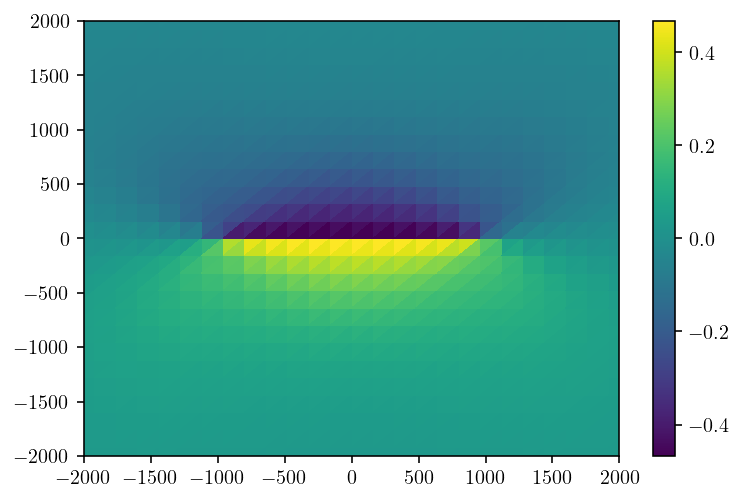

In [134]:
levels = np.linspace(0.20,0.20,11)
cntf = plt.tripcolor(surf_pts[:,0], surf_pts[:,1], surf_tris, soln_reordered[:,0])#, levels = levels, extend="both")
#plt.tricontour(surf_pts[:,0], surf_pts[:,1], surf_tris, rhs[:,0], colors='k', linestyles='-', linewidths=0.5)#, levels = levels, extend="both")
#plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

In [135]:
okada_lhs = np.empty_like((n_els_per_dim, 3, n_els_per_dim, 3))
okada_soln = np.empty_like(soln_reordered)
okada_pts = np.mean(surf_tri_pts, axis = 1)
for i in range(okada_pts.shape[0]):
    success, okada_soln[i], _ = okada_wrapper.dc3dwrapper(alpha, okada_pts[i].tolist(),
                              fault_D + fault_H / 2.0, 90, [-fault_L, fault_L], [-fault_H/2.0, fault_H/2.0],
                              [1.0, 0.0, 0.0])
    assert(success == 0)

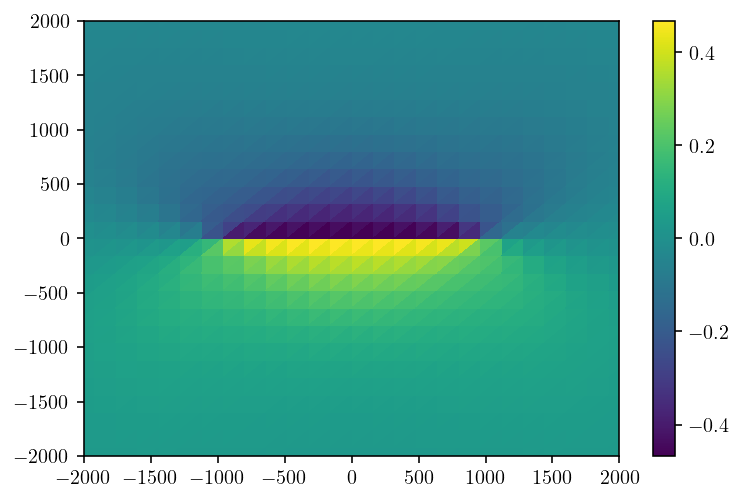

In [136]:
levels = np.linspace(0.20,0.20,11)
cntf = plt.tripcolor(surf_pts[:,0], surf_pts[:,1], surf_tris, okada_soln[:,0])#, levels = levels, extend="both")
#plt.tricontour(surf_pts[:,0], surf_pts[:,1], surf_tris, rhs[:,0], colors='k', linestyles='-', linewidths=0.5)#, levels = levels, extend="both")
#plt.plot(surface_high[0], surface_high[1], 'k-', linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()

# Look here, this is a comparison between Okada and a solution derived from fullspace TDEs. The first row is Okada, the second is the solution from TDEs. The third is error.

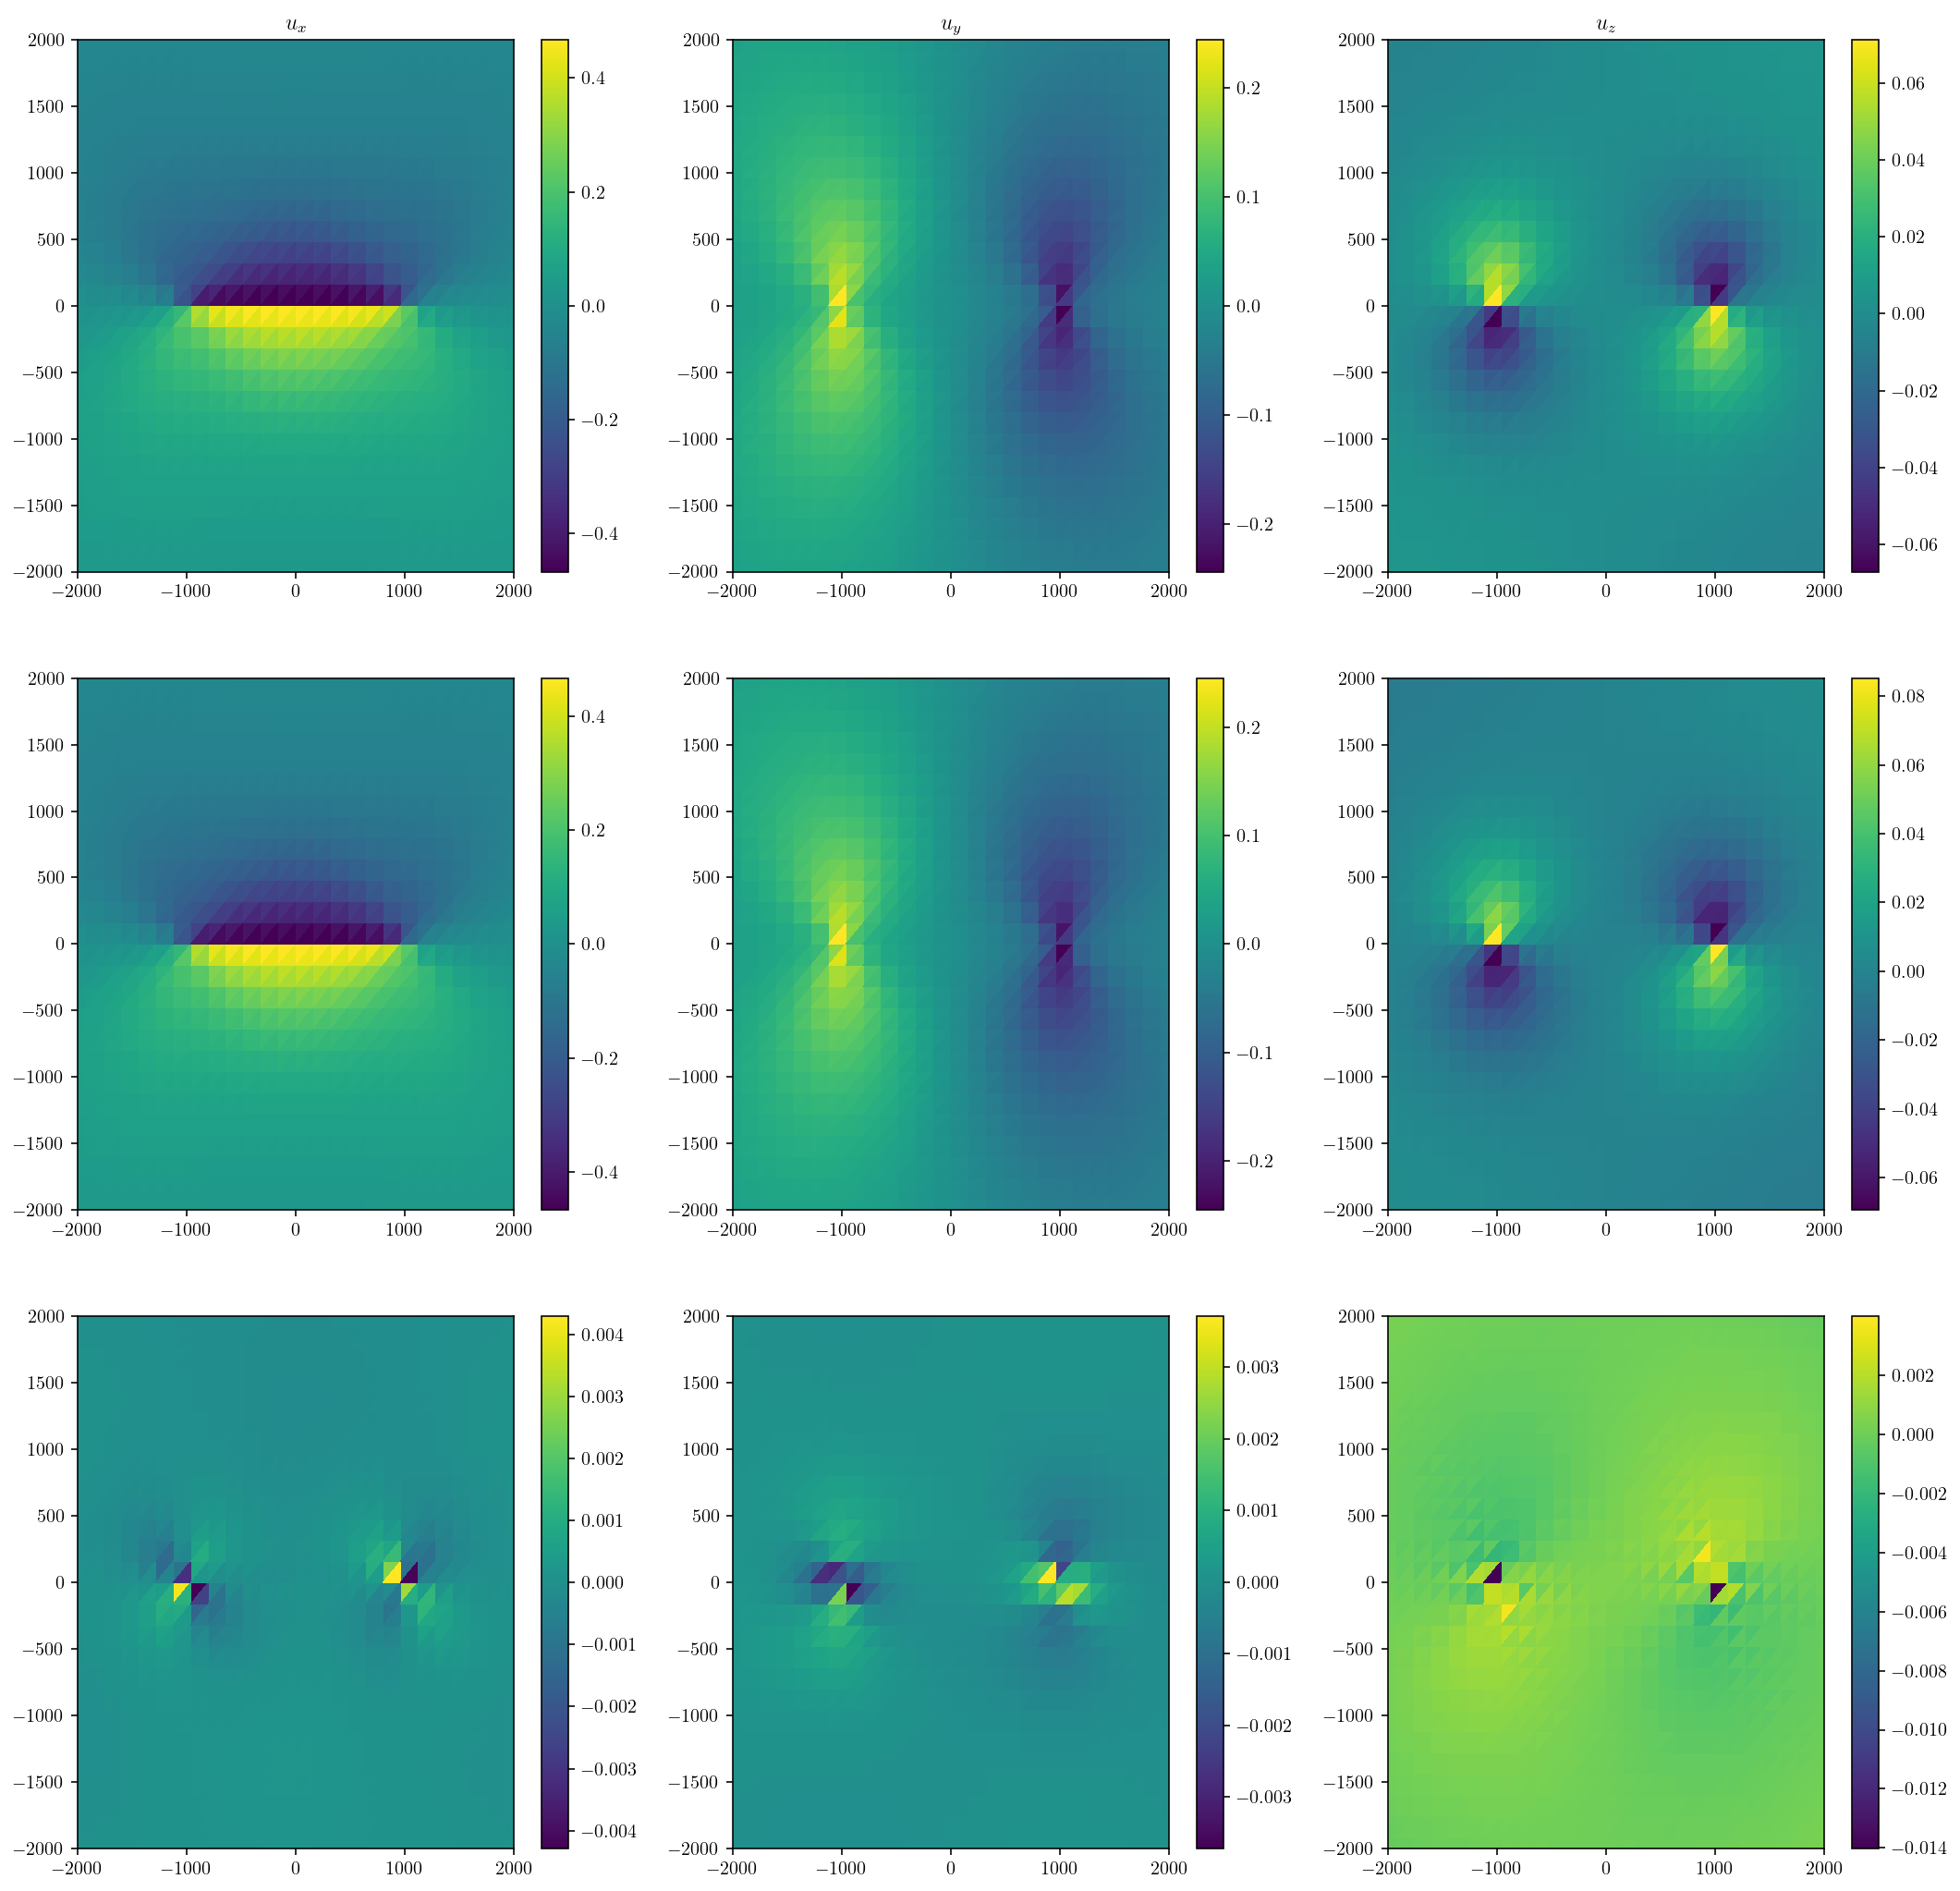

In [155]:
plt.figure(figsize=(18, 18))

dimnames = ['x', 'y', 'z']
for d in range(3):
    plt.subplot(3, 3, d+1)
    cntf = plt.tripcolor(surf_pts[:,0], surf_pts[:,1], surf_tris, okada_soln[:,d])
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    plt.title(f'$u_{dimnames[d]}$')
    
for d in range(3):
    plt.subplot(3, 3, d+4)
    cntf = plt.tripcolor(surf_pts[:,0], surf_pts[:,1], surf_tris, soln_reordered[:,d])
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    
for d in range(3):
    plt.subplot(3, 3, d+7)
    cntf = plt.tripcolor(surf_pts[:,0], surf_pts[:,1], surf_tris, okada_soln[:,d] - soln_reordered[:,d])
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)
    
plt.show()

In [38]:
(surf_pts_latlon, surf_tris), (fault_pts_latlon, fault_tris) = np.load('sa_mesh.npy', allow_pickle=True)

In [42]:
surf_pts_latlon[:,1]

array([-72.91345198, -72.91345198,  32.14640237, ..., -32.45697161, -34.47386135, -67.50046102])

In [43]:
import collect_dem
surf_pts = collect_dem.project(surf_pts_latlon[:,0], surf_pts_latlon[:,1], surf_pts_latlon[:,2], 'utm19K')
fault_pts = collect_dem.project(fault_pts_latlon[:,0], fault_pts_latlon[:,1], fault_pts_latlon[:,2], 'utm19K')

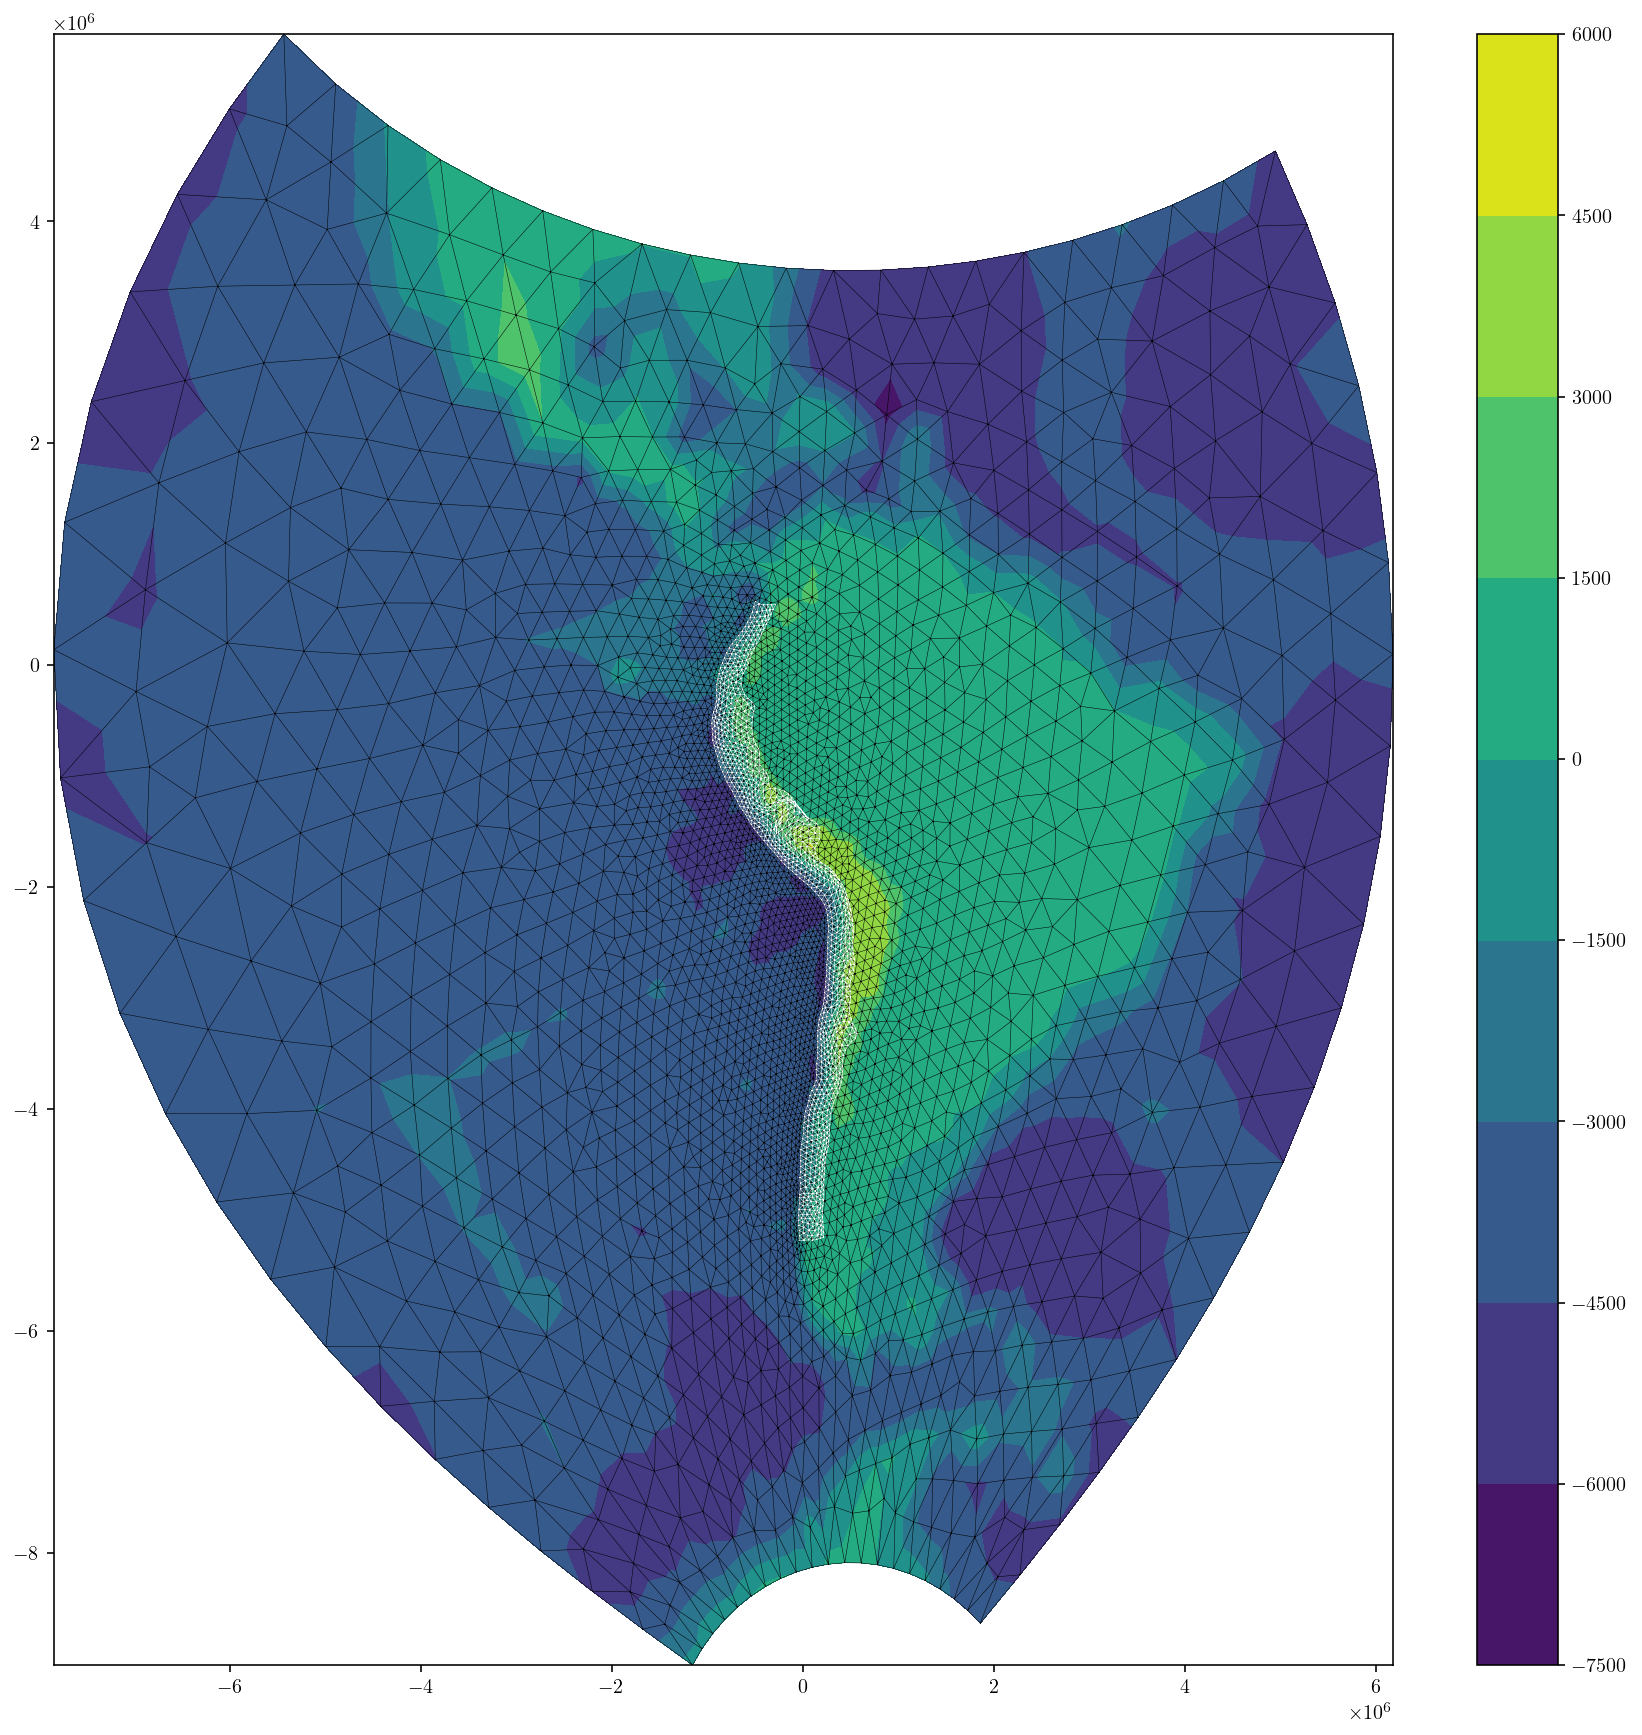

In [44]:
plt.figure(figsize = (15,15))
cntf = plt.tricontourf(surf_pts[:,0], surf_pts[:,1], surf_tris, surf_pts[:,2])
plt.triplot(surf_pts[:,0], surf_pts[:,1], surf_tris, 'k-', linewidth = 0.25)
plt.triplot(fault_pts[:,0], fault_pts[:,1], fault_tris, 'w-', linewidth = 0.25)
plt.colorbar()
plt.show()

In [72]:
surf_tri_pts = surf_pts[surf_tris]
surf_centers = np.mean(surf_tri_pts, axis = 1)
slip = np.zeros((fault_tris.shape[0], 3))
slip[:, 1] = -1.0 # dip slip
fault_pts_tris = fault_pts[fault_tris]
fault_pts_tris[:,2] -= 500
fault_surf_mat = disp_all_pairs(surf_centers, fault_pts_tris, slip, 0.25)

In [73]:
surf_surf_mats = []
offset_steps = [0.02, 0.01]
for offset in offset_steps:
    offset_mats = []
    for d in range(3):
        fictitious_slip = np.zeros((surf_tris.shape[0], 3))
        fictitious_slip[:, d] = 1.0
        surf_centers = np.mean(surf_tri_pts, axis = 1)
        # Offset the observation coordinates by a small amount. 
        surf_centers[:,2] += offset
        offset_mats.append(disp_all_pairs(surf_centers, surf_pts[surf_tris], fictitious_slip, 0.25))
    surf_surf_mats.append(offset_mats)
surf_surf_mat = np.array(surf_surf_mats)

In [74]:
# A simple one step "richardson extrapolation". This trick seems to reduce the "offset error" to basically zero.
extrap = 2 * surf_surf_mat[1] - surf_surf_mat[0]

In [75]:
lhs = np.transpose(extrap, (1, 3, 2, 0)).reshape((surf_tris.shape[0] * 3, surf_tris.shape[0] * 3))
rhs = np.sum(fault_surf_mat, axis=1)

In [76]:
lhs.shape, rhs.shape

((20412, 20412), (6804, 3))

In [77]:
soln = np.linalg.solve(lhs, rhs.flatten()).reshape((-1, 3))

In [78]:
soln_reordered = np.empty_like(soln)
soln_reordered[:,0] = soln[:,1]
soln_reordered[:,1] = soln[:,0]
soln_reordered[:,2] = soln[:,2]

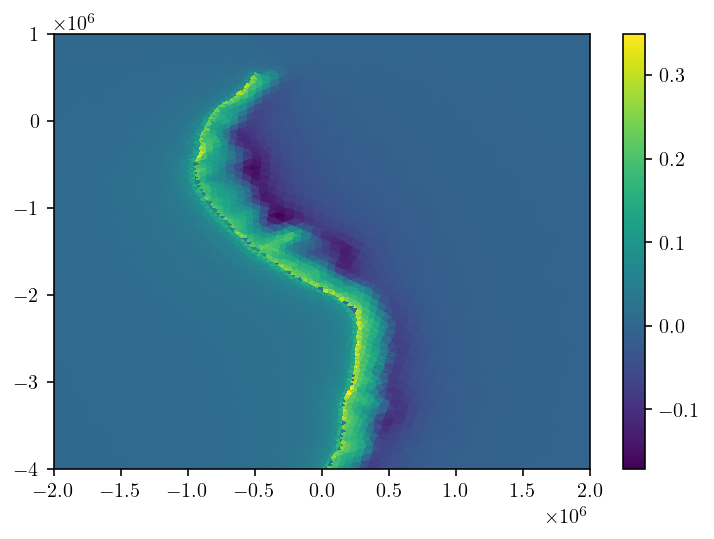

In [79]:
cntf = plt.tripcolor(surf_pts[:,0], surf_pts[:,1], surf_tris, rhs[:,2])#soln_reordered[:,0])
plt.colorbar(cntf)
plt.xlim([-2e6,2e6])
plt.ylim([-4e6,1e6])
#plt.axis('equal')
plt.show()